<a href="https://colab.research.google.com/github/soline013/Machine-Learning-ML/blob/master/Style-Transfer/Neural_Style_Transfer_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tf.keras를 사용한 Neural Style Transfer

Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License")

[tf.keras를 사용한 Neural Style Transfer](https://www.tensorflow.org/tutorials/generative/style_transfer?hl=ko)

[Google Colab](https://colab.research.google.com/drive/1byj3WwJVLUYx6F17TzwKE7YpgZ5hknNl?hl=ko#scrollTo=jo5PziEC4hWs)

## Import

In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
#Image Download. Content Image & Style Image.
#I will use own image.

# https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg
content_path_second = tf.keras.utils.get_file('2.jpg', 'https://user-images.githubusercontent.com/66259854/105966323-d4ce9980-60c7-11eb-9bc8-06144451ff7e.jpg')
content_path = tf.keras.utils.get_file('1.jpg', 'https://user-images.githubusercontent.com/66259854/105965878-4e19bc80-60c7-11eb-903b-08b34e8aa93a.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path_second = tf.keras.utils.get_file('#2.jpg', 'https://user-images.githubusercontent.com/66259854/105966349-e0ba5b80-60c7-11eb-94dd-890450e78f03.jpg')
style_path = tf.keras.utils.get_file('#1.jpg', 'https://user-images.githubusercontent.com/66259854/105966346-def09800-60c7-11eb-9613-2db78fe84b7d.jpg')

1630208/1629935 [==============================] - 0s 0us/step


## Input Visualization

In [4]:
#Image Loading Function.
def load_img(path_to_img):
  max_dim = 512 #Max Image Size: 512.
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)
  #print(img.shape)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  #print(img.shape) #Check shape changes.
  return img

In [5]:
#Image Output Function.
#New imshow() by using plt.imshow.
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

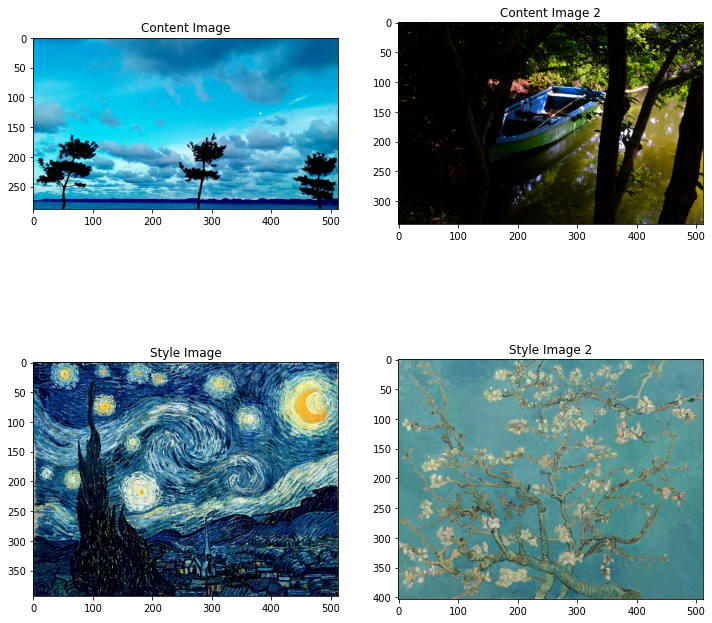

In [6]:
content_image = load_img(content_path)
content_image_second = load_img(content_path_second)
style_image = load_img(style_path)
style_image_second = load_img(style_path_second)

plt.subplot(2, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(2, 2, 2)
imshow(content_image_second, 'Content Image 2')

plt.subplot(2, 2, 3)
imshow(style_image, 'Style Image')
plt.subplot(2, 2, 4)
imshow(style_image_second, 'Style Image 2')

In [7]:
print(content_image.shape)
print(content_image_second.shape)

(1, 288, 512, 3)
(1, 339, 512, 3)


In [8]:
print(style_image.shape)
print(style_image_second.shape)

(1, 393, 512, 3)
(1, 403, 512, 3)


## Fast Style Transfer by using TF-Hub

In [9]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

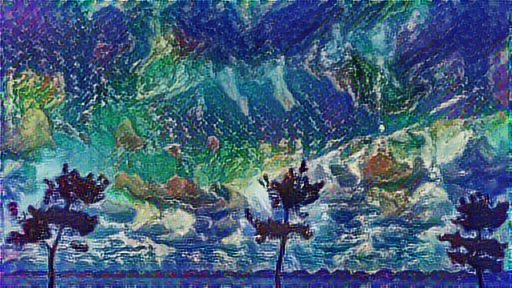

In [10]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image_1st = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
stylized_image_2nd = hub_module(tf.constant(content_image_second), tf.constant(style_image_second))[0]
stylized_image_3th = hub_module(tf.constant(content_image_second), tf.constant(style_image))[0]
stylized_image_4th = hub_module(tf.constant(content_image), tf.constant(style_image_second))[0]
tensor_to_image(stylized_image_1st)

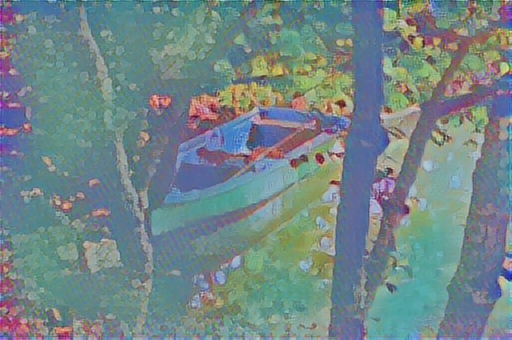

In [11]:
tensor_to_image(stylized_image_2nd)

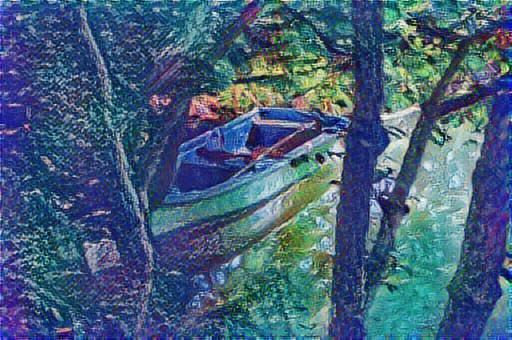

In [12]:
tensor_to_image(stylized_image_3th)

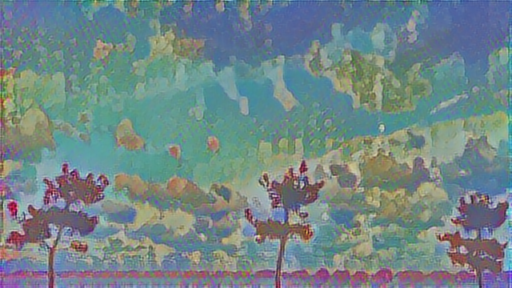

In [13]:
tensor_to_image(stylized_image_4th)

## Content & Style Representation Define

In [14]:
#Load VGG Model.
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 3s 0us/step


TensorShape([1, 1000])

In [15]:
#Apply VGG to Image.
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('fountain', 0.14060411),
 ('flagpole', 0.10617049),
 ('pole', 0.091056),
 ('parachute', 0.06684582),
 ('crane', 0.057746913)]

In [16]:
#Load VGG, and Print Each Layer Name.
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
print()

for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 0s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [17]:
#We'll select middle layers for content and style.
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print(num_content_layers, num_style_layers)

1 5


## Makes Model

In [18]:
def vgg_model(layer_names):
  """Makes VGG model that returns the output of middle layer transfer as matrix"""
  #Load pretrained VGG with imagenet dataset.
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.tranable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [19]:
style_extractor = vgg_model(style_layers)
style_outputs = style_extractor(style_image*255)

#Let's see statistics about the output of each layer.
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  Shapr: ", output.numpy().shape)
  print("  Min: ", output.numpy().min())
  print("  Max: ", output.numpy().max())
  print("  Mean: ", output.numpy().mean())
  print()

block1_conv1
  Shapr:  (1, 393, 512, 64)
  Min:  0.0
  Max:  826.5136
  Mean:  30.497757

block2_conv1
  Shapr:  (1, 196, 256, 128)
  Min:  0.0
  Max:  3589.527
  Mean:  198.66678

block3_conv1
  Shapr:  (1, 98, 128, 256)
  Min:  0.0
  Max:  8822.238
  Mean:  187.61864

block4_conv1
  Shapr:  (1, 49, 64, 512)
  Min:  0.0
  Max:  21060.078
  Mean:  713.9721

block5_conv1
  Shapr:  (1, 24, 32, 512)
  Min:  0.0
  Max:  4965.1445
  Mean:  58.013824



## Calculates Style

In [20]:
#Gram Matrix Function.
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract Style & Content

In [21]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_model(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainabel = False

  def call(self, inputs):
    """Input is 0 ~ 1 real number."""
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    #Gram Matrix Function.
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [22]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

print('Style:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    Shape: ", output.numpy().shape)
  print("    Min: ", output.numpy().min())
  print("    Max: ", output.numpy().max())
  print("    Mean: ", output.numpy().mean())
  print()

print("Content:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    Shape: ", output.numpy().shape)
  print("    Min: ", output.numpy().min())
  print("    Max: ", output.numpy().max())
  print("    Mean: ", output.numpy().mean())

Style:
   block1_conv1
    Shape:  (1, 64, 64)
    Min:  0.0
    Max:  98352.58
    Mean:  2201.4678

   block2_conv1
    Shape:  (1, 128, 128)
    Min:  0.0
    Max:  299902.28
    Mean:  31367.143

   block3_conv1
    Shape:  (1, 256, 256)
    Min:  0.0
    Max:  757404.75
    Mean:  25721.094

   block4_conv1
    Shape:  (1, 512, 512)
    Min:  0.0
    Max:  21464706.0
    Mean:  348837.53

   block5_conv1
    Shape:  (1, 512, 512)
    Min:  0.0
    Max:  233306.69
    Mean:  1946.2766

Content:
   block5_conv2
    Shape:  (1, 18, 32, 512)
    Min:  0.0
    Max:  1536.1515
    Mean:  14.769131


In [23]:
print(results['content'])
print(results['style'])

{'block5_conv2': <tf.Tensor: shape=(1, 18, 32, 512), dtype=float32, numpy=
array([[[[  0.       ,   0.       , 176.60588  , ...,   0.       ,
           90.89155  ,  42.14328  ],
         [ 26.187813 ,   0.       ,   0.       , ...,   0.       ,
          126.10723  ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
          100.89672  ,   0.       ],
         ...,
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
           39.26296  ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
           78.43905  ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
           78.7076   ,   0.       ]],

        [[  0.       ,   0.       , 191.49803  , ...,   0.       ,
            0.       ,  12.921322 ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
          

## Gradient Descent Algorithm

In [24]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

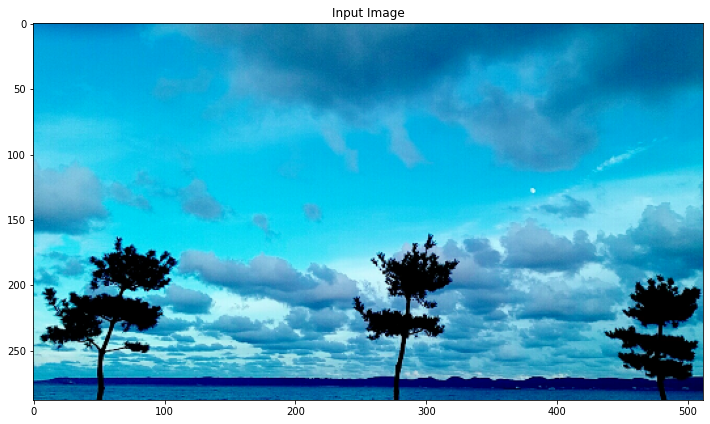

In [25]:
#First Input Image.
#Content Image.
#Fill the image to optimize by using tf.Variable, and initialize as content image. 
input_image = tf.Variable(content_image)
plt.figure()
imshow(input_image, title="Input Image")

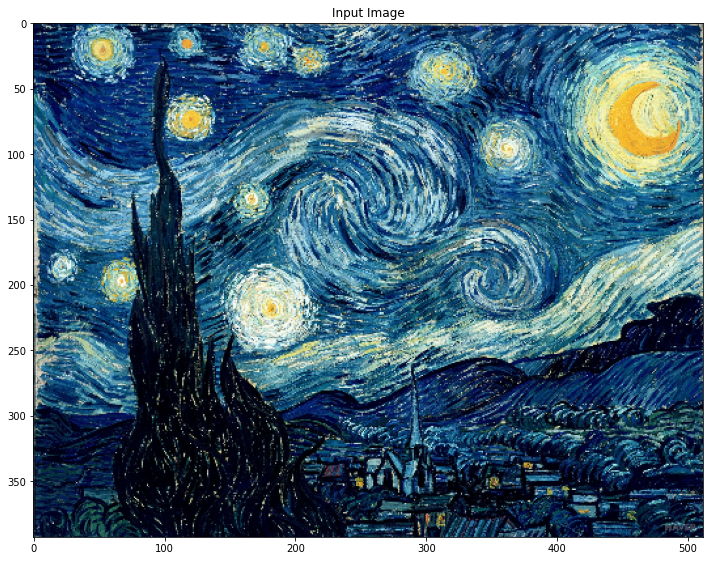

In [26]:
#Second Input Image.
#Style Image.
input_image_style = tf.Variable(style_image)
imshow(input_image_style, title="Input Image")

In [27]:
#Pixel value is real number, then we define function that cliping 0 to 1.
def clip_0_1(input_image):
  return tf.clip_by_value(input_image, clip_value_min=0.0, clip_value_max=1.0)

In [28]:
'''
2016년 Image Style Transfer Using Convolutional Neural Networks에서는
L-BFGS를 L-BFGS를 사용할 수 있는 방법을 찾아보자.
'''
#Generate Optimizer.
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [29]:
#Total Loss = Content Loss + Style Loss (Weight Sum)
style_weight = 1e-2
content_weight = 1e-5 #1e-4.

In [30]:
'''
def style_content_loss(outputs):
  #Outputs.
  style_outputs = outputs['style']
  content_outputs = outputs['content']

  #Style Loss.
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                        for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  #Content Loss.
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                          for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  
  alpha = 1
  beta = 10000
  loss = beta*style_loss + alpha*content_loss
  return loss
'''

"\ndef style_content_loss(outputs):\n  #Outputs.\n  style_outputs = outputs['style']\n  content_outputs = outputs['content']\n\n  #Style Loss.\n  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)\n                        for name in style_outputs.keys()])\n  style_loss *= style_weight / num_style_layers\n\n  #Content Loss.\n  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)\n                          for name in content_outputs.keys()])\n  content_loss *= content_weight / num_content_layers\n  \n  alpha = 1\n  beta = 10000\n  loss = beta*style_loss + alpha*content_loss\n  return loss\n"

In [31]:
def style_content_loss(outputs):
  #Outputs.
  style_outputs = outputs['style']
  content_outputs = outputs['content']

  #Style Loss.
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                        for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  #Content Loss.
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                          for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  
  loss = style_loss + content_loss
  return loss

## Train Model

In [32]:
#Image update with tf.GradientTape.
@tf.function()
def train_step(input_image):
  with tf.GradientTape() as tape:
    outputs = extractor(input_image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, input_image)
  opt.apply_gradients([(grad, input_image)])
  input_image.assign(clip_0_1(input_image))

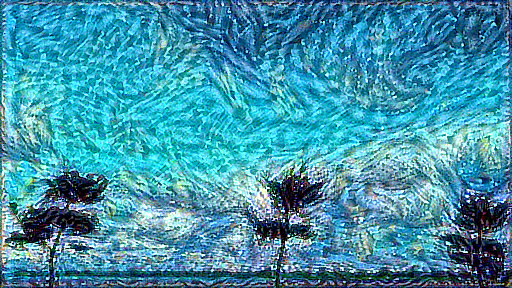

In [33]:
for _ in range(51):
  train_step(input_image)

tensor_to_image(input_image)

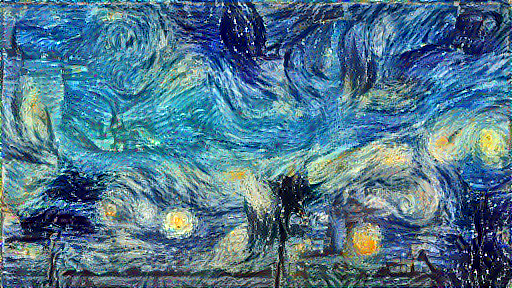

Training Step: 2000
Total Time: 104.0


In [34]:
import time
start = time.time()

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(input_image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(input_image))
  print("Training Step: {}".format(step))
  
end = time.time()
print("Total Time: {:.1f}".format(end-start))

## Total Variation Loss

In [35]:
def high_pass_x_y(input_image):
  x_var = input_image[:,:,1:,:] - input_image[:,:,:-1,:]
  y_var = input_image[:,1:,:,:] - input_image[:,:-1,:,:]

  return x_var, y_var

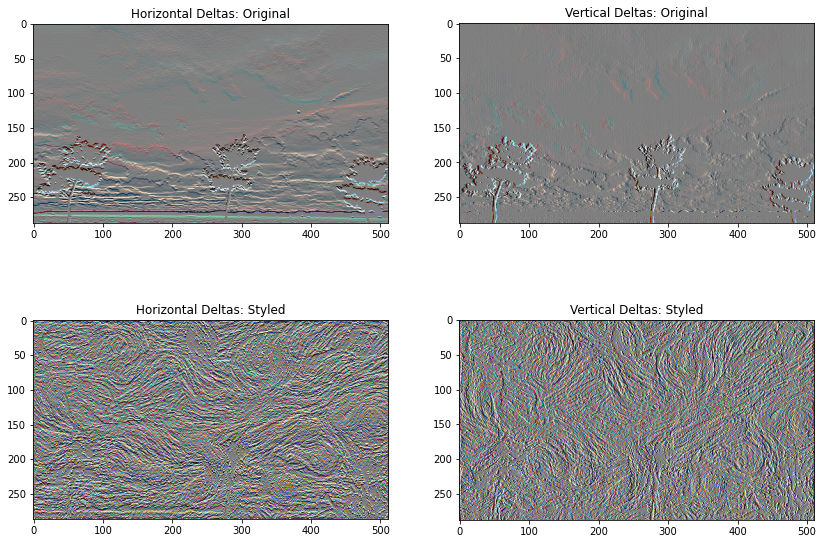

In [36]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(input_image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

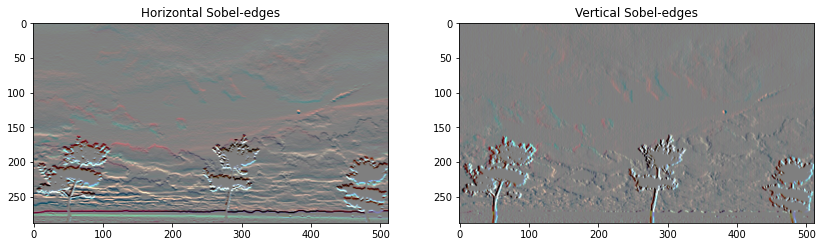

In [37]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [38]:
def total_variation_loss(input_image):
  x_deltas, y_deltas = high_pass_x_y(input_image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [39]:
total_variation_loss(input_image).numpy()

124538.26

In [40]:
tf.image.total_variation(input_image).numpy()

array([124538.26], dtype=float32)

## Optimization

In [41]:
total_variation_weight = 30

In [42]:
@tf.function()
def train_step(input_image):
  with tf.GradientTape() as tape:
    outputs = extractor(input_image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight * tf.image.total_variation(input_image)

  grad = tape.gradient(loss, input_image)
  opt.apply_gradients([(grad, input_image)])
  input_image.assign(clip_0_1(input_image))

In [43]:
#Initialize.
input_image = tf.Variable(content_image)

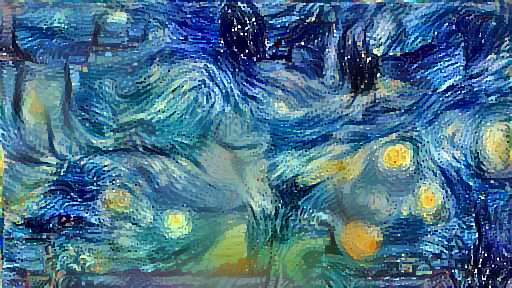

Training Step: 2000
Total Time: 108.3


In [44]:
import time
start = time.time()

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(input_image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(input_image))
  print("Training Step: {}".format(step))

end = time.time()
print("Total Time: {:.1f}".format(end-start))

In [45]:
file_name = 'stylized-image.png'
tensor_to_image(input_image).save(file_name)

'''
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)
'''

'\ntry:\n  from google.colab import files\nexcept ImportError:\n   pass\nelse:\n  files.download(file_name)\n'